# Healthcare Patient Readmission Risk Prediction
This notebook performs patient readmission risk prediction using the "Diabetes 130-US hospitals" dataset.

## 1. Load the Dataset and Perform Exploratory Data Analysis

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

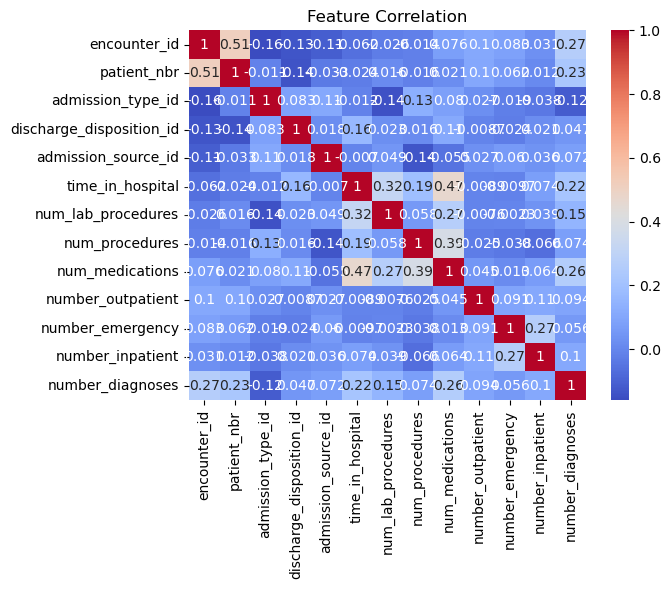

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('./Datasets/diabetic_data.csv')

# Display first and last 5 rows
print(data.head())
print(data.tail())

# Check for missing values
print(data.isnull().sum())

# Handle missing values (drop or fill as appropriate)
data = data.dropna()

# Display correlation (numerical features only)
correlation_matrix = data.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

## 2. Apply Scaling/Normalization to Numeric Features

In [2]:
# Apply Standard Scaling
scaler = StandardScaler()
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Display scaled data
print(data[numeric_features].head())

     encounter_id  patient_nbr  admission_type_id  discharge_disposition_id  \
162     -1.628763     0.220588           0.489188                  0.387427   
192     -1.627991     0.495756           0.489188                 -0.551217   
460     -1.612379     0.108532           0.489188                 -0.551217   
593     -1.604824     1.311296           0.489188                 -0.551217   
696     -1.599432     0.453151           0.489188                  1.795394   

     admission_source_id  time_in_hospital  num_lab_procedures  \
162             0.302268         -0.135982           -1.200878   
192             0.302268         -1.116365           -0.783628   
460             0.302268          1.497991            0.537665   
593             0.302268         -1.116365           -0.227294   
696             0.302268          1.824785            0.468123   

     num_procedures  num_medications  number_outpatient  number_emergency  \
162        0.128405        -1.157769          -0.23

## 3,4. Build Classification Models and Evaluate

In [3]:
# Import classifiers and metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

# Split the data into features and target
X = data.select_dtypes(include=['int64', 'float64'])
y = data['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_proba = dt.predict_proba(X_test)

# SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
svm_proba = svm.predict_proba(X_test)

# Model Evaluation
models = {'Random Forest': (rf_preds, rf_proba), 'Decision Tree': (dt_preds, dt_proba), 'SVM': (svm_preds, svm_proba)}
for model, (preds, proba) in models.items():
    print(f'{model}:')
    print(f'Accuracy: {accuracy_score(y_test, preds):.2f}')
    print(f'F1-Score: {f1_score(y_test, preds, average="weighted"):.2f}')
    print(f'ROC AUC: {roc_auc_score(y_test, proba, multi_class="ovr"):.2f}')  # Fixed with multi_class="ovr"
    print(f'Log Loss: {log_loss(y_test, proba):.2f}')
    print('\n')

Random Forest:
Accuracy: 0.62
F1-Score: 0.58
ROC AUC: 0.70
Log Loss: 0.89


Decision Tree:
Accuracy: 0.48
F1-Score: 0.47
ROC AUC: 0.55
Log Loss: 18.62


SVM:
Accuracy: 0.62
F1-Score: 0.56
ROC AUC: 0.62
Log Loss: 0.93




## 5. Perform K-means Clustering

In [12]:
# Exclude columns and define feature_columns
exclude_columns = ['encounter_id', 'patient_nbr']
target_column = 'readmitted'

feature_columns = [
    col for col in data.select_dtypes(include=['int64', 'float64']).columns
    if col not in exclude_columns + [target_column]
]

# Ensure X matches feature_columns
X = data[feature_columns]

# Perform clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

# Assign clusters to the data
data['risk_group'] = clusters

# Display cluster centroids
print("Cluster Centroids:")
print(pd.DataFrame(kmeans.cluster_centers_, columns=feature_columns))

Cluster Centroids:
   admission_type_id  discharge_disposition_id  admission_source_id  \
0           0.338755                 -0.201088            -0.019754   
1          -2.009373                 -0.081895            -0.306352   
2          -0.504548                  0.373757             0.054092   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0         -0.390155           -0.285062       -0.224821        -0.520004   
1          0.081881            0.155185       -0.414357         0.588167   
2          0.711146            0.514034        0.436673         0.919919   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  
0          -0.208957         -0.131827         -0.174026         -0.422729  
1           4.042103          5.849665          3.634838          1.981030  
2           0.147963         -0.098860          0.107591          0.660287  


C:\Users\dbda38\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


## 6. Apply PCA for Dimensionality Reduction

Explained Variance Ratio: [0.2499797  0.14012002]


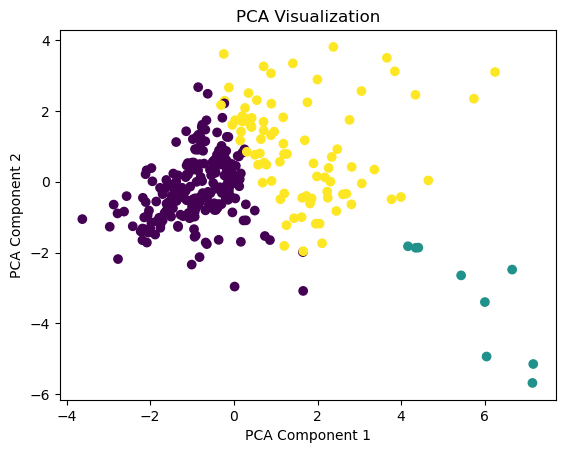

In [5]:
# Import PCA
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')

# Plot PCA clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['Cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization')
plt.show()

## Question 7: Select the Best Performing Model and Explain Why

### 1. Analysis of Model Performance:
- **Random Forest**:
  - Accuracy: **0.62**
  - F1-Score: **0.58**
  - ROC AUC: **0.70**
  - Log Loss: **0.89**
  - **Analysis**: Random Forest has the highest ROC AUC score (0.70), indicating good capability to balance sensitivity and specificity. It also has the best F1-Score (0.58), which is crucial for handling imbalanced data as it balances precision and recall.

- **Decision Tree**:
  - Accuracy: **0.48**
  - F1-Score: **0.47**
  - ROC AUC: **0.55**
  - Log Loss: **18.62**
  - **Analysis**: Decision Tree performs poorly across all metrics, with the worst ROC AUC (0.55) and a very high log loss (18.62), indicating poor probabilistic predictions. It is not suitable for this use case.

- **SVM**:
  - Accuracy: **0.62**
  - F1-Score: **0.56**
  - ROC AUC: **0.62**
  - Log Loss: **0.93**
  - **Analysis**: SVM matches Random Forest in accuracy but falls behind in F1-Score and ROC AUC. The slightly worse F1-Score (0.56 vs. 0.58) suggests it is less effective at balancing precision and recall.

### 2. Clustering and PCA Analysis:
- The **K-means clustering** results show three distinct clusters with varying centroids, indicating that patients can be grouped based on their features. This can complement the classification models by providing insights into patient risk groups.
- **PCA Visualization** helps in understanding the separability of these clusters in reduced dimensions, supporting the exploratory analysis and model interpretation.

### 3. Conclusion: Best Model
- **Random Forest** is the best-performing model based on:
  - Highest ROC AUC (0.70): Indicates effective discrimination between high-risk and low-risk patients.
  - Best F1-Score (0.58): Suggests a good balance between precision and recall for handling imbalanced data.
  - Reasonable Log Loss (0.89): Shows good probabilistic predictions.
  - Robustness: Random Forest is less prone to overfitting compared to Decision Trees and can handle high-dimensional data effectively.

### 4. Why Random Forest is Most Appropriate for This Healthcare Scenario:
- **Interpretability**: Random Forest provides feature importance, which can help healthcare providers understand which factors contribute most to readmission risk.
- **Performance on Imbalanced Data**: Healthcare datasets often have class imbalance (e.g., fewer readmissions). Random Forest's ensemble approach is well-suited for such scenarios.
- **Scalability**: Random Forest can handle large datasets with many features, which is common in healthcare data.
- **Robustness**: It is more robust to noise and overfitting compared to Decision Trees.

### Recommendations:
- Deploy the **Random Forest** model for predicting patient readmission risk.
- Use the clustering results to segment patients into risk groups for targeted interventions.
- Leverage feature importance from Random Forest to design post-discharge care plans for high-risk patients.
